In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import src.vncNet as vncNet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import seaborn as sns

from src.plot_utils import *
from src.sim_utils import *

Load in connectome data

In [2]:
Wpd = pd.read_csv("../data/manc t1 connectome data/W_20231020_DNtoMN_unsorted.csv")
W = Wpd.drop(columns="bodyId_pre").to_numpy().astype(float) # changing the type to float is what allows it to work, TODO catch this and fix
wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)

Get W indexes of the BDN2 neurons, which are manc bodyIds 10093 and 10339. The cell shows the verification that these indexes correspond to 2 neurons of systemic type DNxl058, which are the BDN2s.

In [3]:
def bodyIdToIdx(wTable,bodyIdList):
    return wTable[wTable["bodyId"].isin(bodyIdList)].index.to_numpy().astype(int)

bdn2s = bodyIdToIdx(wTable,[10093, 10339])

display(wTable.loc[bdn2s])

,Unnamed: 0,bodyId,type,class,subclass,hemilineage,size,predictedNt,predictedNtProb,somaSide,motor module,step contribution
31,31,10093,DNxl058,descending neuron,xl,NaN,7124816452,acetylcholine,0.957519,NaN,NaN,NaN
132,132,10339,DNxl058,descending neuron,xl,NaN,7435937069,acetylcholine,0.941600,NaN,NaN,NaN


Run simulation where you activate both BDN2s. I added a "runQuick" option to run at a higher error tolerance than paper-quality, and get the result faster.

In [4]:
stimNeurons = bdn2s
stimI = 250
T = 1
dt = 0.001

seedOfSeeds = np.random.randint(100000)


sim = vncNet.Simulation(W)
sim.set_time(T,dt)

sim.set_input(sim.pulse_input(0.02,T-0.1,stimI,stimNeurons)) # pulse input starting at 20 ms and ending 100 ms before simulation end time

seeds = np.random.default_rng(seedOfSeeds).integers(10000,size=4)
sim.set_tau_distribution(0.02,0.002,seed=seeds[0])
sim.set_a_distribution(1,0.1,seed=seeds[1])
sim.set_threshold_distribution(7.5,0.6,seed=seeds[2])
sim.set_synapse_multipliers(0.03,0.03)
sim.set_fr_distribution(200,10,seed=seeds[3])
sim.set_sizes(wTable["size"])

sim.run(runQuick=True)

/Users/sarahpugliese/Documents/python/bdn2cpg/src/vncNet.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/Users/sarahpugliese/Documents/python/bdn2cpg/src/vncNet.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes == 0] = normSize #TODO this isn't great


Plot output

/Users/sarahpugliese/Documents/python/bdn2cpg/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


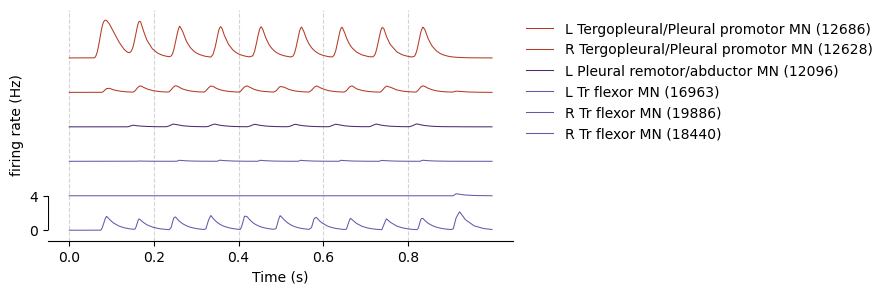

In [5]:
R = sim.R # firing rates of each neuron
mns = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"]) # data corresponding to motor neurons

plt.figure()
ax = plot_R_traces_stacked_by_module(R,mns,activeOnly=True,space=4)
add_tAxis(ax,T,5)

plt.show()